In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')

In [2]:
import importlib 
import var_net as var_net
import base_net as base_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)
importlib.reload(base_net)



<module 'base_net' from '../src/base_net.py'>

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = .1 # априорная дисперсия
epoch_num = 25 #количество эпох
lamb = [0.01, 0.1, 1,  10, 100]

hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_mnist'

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)





In [ ]:
t.manual_seed(0)
for lam in lamb[::-1]:
    for start in range(start_num):                    
            net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device, 
                                            prior_sigma = prior_sigma), 
                                 base_net.BaseLayer(hidden_num, 10, device, prior_sigma=prior_sigma,
                                          act=lambda x:x))
            
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                utils.train_batches_net(train_loader,len(train_data),  net, device, loss_fn, optim, lam, label)
                if e%5 == 0:
                    print (utils.test_acc_net(net, device, test_loader))
            t.save(net.state_dict(), os.path.join(path_to_save, 'base_net_lam_{}_start_{}.cpk'.format(lam, start)))

../src/base_net.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
lambda 100, epoch 1: 2.2617302:   1%|▏         | 3/235 [00:00<00:08, 26.38it/s]

0.8877


lambda 100, epoch 6: 1.0466425:   1%|▏         | 3/235 [00:00<00:08, 26.78it/s]

0.902


lambda 100, epoch 11: 0.8276216:   1%|▏         | 3/235 [00:00<00:08, 25.88it/s] 

0.9025


lambda 100, epoch 16: 0.7412223:   1%|▏         | 3/235 [00:00<00:09, 25.75it/s] 

0.9028


lambda 100, epoch 21: 0.6910366:   1%|▏         | 3/235 [00:00<00:10, 22.15it/s] 

0.9041


lambda 100, epoch 1: 2.4046037:   1%|▏         | 3/235 [00:00<00:10, 22.01it/s]

0.8869


lambda 100, epoch 6: 1.1372594:   1%|          | 2/235 [00:00<00:14, 16.44it/s]

0.902


lambda 100, epoch 11: 0.87555873:   1%|▏         | 3/235 [00:00<00:10, 21.23it/s]

0.9043


lambda 100, epoch 16: 0.7280421:   1%|          | 2/235 [00:00<00:14, 16.43it/s]

0.9045


lambda 100, epoch 21: 0.67542005:   1%|▏         | 3/235 [00:00<00:12, 18.92it/s]

0.9062


lambda 100, epoch 1: 2.0287805:   1%|          | 2/235 [00:00<00:14, 15.92it/s]

0.8873


lambda 100, epoch 6: 0.9424333:   1%|          | 2/235 [00:00<00:16, 14.08it/s]

0.9022


lambda 100, epoch 11: 0.7340579:   1%|          | 2/235 [00:00<00:17, 13.67it/s]

0.9034


lambda 100, epoch 16: 0.6889207:   1%|          | 2/235 [00:00<00:15, 14.83it/s]

0.9041


lambda 100, epoch 21: 0.6647937:   1%|          | 2/235 [00:00<00:13, 17.62it/s]

0.9058


lambda 100, epoch 1: 2.4603758:   1%|          | 2/235 [00:00<00:14, 16.59it/s]

0.8872


lambda 100, epoch 6: 1.1562622:   1%|          | 2/235 [00:00<00:15, 15.19it/s]

0.9054


lambda 100, epoch 11: 0.8462475:   1%|          | 2/235 [00:00<00:15, 15.50it/s]

0.9046


lambda 100, epoch 16: 0.73404056:   1%|          | 2/235 [00:00<00:14, 16.54it/s]

0.9066


lambda 100, epoch 17: 0.72246456:  32%|███▏      | 75/235 [00:04<00:10, 14.70it/s]

In [7]:
net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device, 
                                            prior_sigma = prior_sigma), 
                                 base_net.BaseLayer(hidden_num, 10, device, prior_sigma=prior_sigma,
                                          act=lambda x:x))   

net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        
        net.load_state_dict(t.load(os.path.join(path_to_save, 'base_net_lam_{}_start_{}.cpk'.format(lam, s))))        
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader), mode='base'))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_base.json'),'w') as out:
    out.write(json.dumps(lam_results))  

0.01 0
0.01 1
0.01 2
0.01 3
0.01 4
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
1 0
1 1
1 2
1 3
1 4
10 0
10 1
10 2
10 3
10 4
100 0
100 1
100 2
100 3
100 4


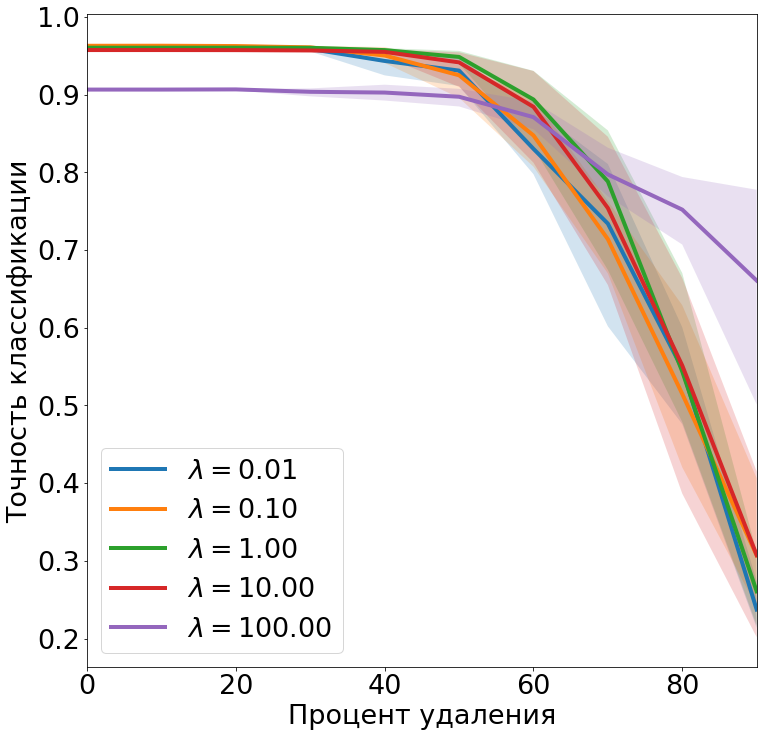

In [9]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Base')
#plt.show()
